In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from IPython.display import Image
warnings.filterwarnings('ignore')

(60000, 28, 28)
(10000, 28, 28)
uint8
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0 

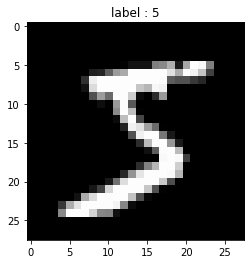

1.0
0.0
(60000,)
(60000, 10)
float64
(48000, 784)
(12000, 784)
(48000,)
(12000,)
(48000, 10)
(12000, 10)


In [2]:
# MNISTデータをmodel入力用に整形
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(X_train.shape) # (60000, 28, 28)
print(X_test.shape) # (10000, 28, 28)
print(X_train[0].dtype) # uint8
print(X_train[0])
# 1次元にする
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

# 一つ可視化
import matplotlib.pyplot as plt
%matplotlib inline
index = 0
image = X_train[index].reshape(28,28)
# X_train[index]: (784,)
# image: (28, 28)
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

# scaleを0 ~ 255から0 ~ 1にする
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

# OHE作成
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

# トレーニングとテストデータに分割
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)
print(y_train.shape) # (12000, 784)
print(y_val.shape) # (12000, 784)

# 分割後のyにOHE適用
y_train = enc.transform(y_train[:, np.newaxis])
y_val = enc.transform(y_val[:, np.newaxis])
print(np.shape(y_train))
print(np.shape(y_val))

In [3]:
# ミニバッチ
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]


In [4]:
# 結果確認、分析用の関数
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# scoreまとめ表示
def eval_accuracy(model, X_test, y_test, model_name):
    pred_y = model.predict(X_test)
    nn_result = pd.DataFrame(
        [accuracy_score(y_test, pred_y), precision_score(y_test, pred_y, average='micro'), recall_score(y_test, pred_y, average='micro')],
        index=['Accuracy', 'Precision', 'Recall'],
        columns=[model_name]
    )
    return nn_result

# 損失値の推移
def display_loss_graph(model):
    iter_list = list(range(len(model.loss_train)))
    plt.scatter(iter_list, model.loss_train, label="train loss")
    plt.scatter(iter_list, model.loss_val, label="test loss")
    plt.ylabel('loss')
    plt.xlabel('iter')
    plt.legend()
    plt.show()

In [5]:
class ScratchDeepNeuralNetrowkClassifier():
    def __init__(self, batch_size = 20, n_features = 784, n_nodes1 = 400, n_nodes2 = 200, n_output = 10, sigma = 0.02 ,lr = 0.01, epoch = 10, activation_func = "Tanh", ada_grad = True, verbose=True):
        self.verbose = verbose
        # 一度に学習させるデータの数
        self.batch_size = batch_size
        # 説明変数の特徴量数
        self.n_features = n_features
        # 1層目のnode数
        self.n_nodes1 = n_nodes1
        # 2層目のnode数
        self.n_nodes2 = n_nodes2 
        # 出力層のnode数
        self.n_output = n_output
        # 正規分布の平均値
        self.sigma = sigma
        # 学習率
        self.lr = lr
        # 学習回数
        self.epoch = epoch
        # 活性化関数
        self.activation_func = activation_func
        # adaGrad
        self.ada_grad = ada_grad

        self.loss_train = []
        self.loss_val = []
   
    def fit(self, X, y, X_val=None, y_val=None):
        # self.sigma : ガウス分布の標準偏差
        # self.lr : 学習率
        # self.n_nodes1 : 1層目のノード数
        # self.n_nodes2 : 2層目のノード数
        # self.n_output : 出力層のノード数

        # SGD: Stochastic Gradient Descent、確率的勾配降下法
        # FC:  結合層
        optimizer = SGD(self.lr, self.ada_grad)
        self.FC1 = FC(self.n_features, self.n_nodes1, SimpleInitializer(self.sigma, self.activation_func), optimizer)
        self.activation1 = self.__activation_func()
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, SimpleInitializer(self.sigma, self.activation_func), optimizer)
        self.activation2 = self.__activation_func()
        self.FC3 = FC(self.n_nodes2, self.n_output, SimpleInitializer(self.sigma, self.activation_func), optimizer)
        self.activation3 = Softmax()

        for _ in range(self.epoch):
            # 全データを使わず一部のデータを使って重みを算出する
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size)
            for mini_X_train, mini_y_train in get_mini_batch:
                # 各層のA, Zを計算
                Z_out = self.forward(mini_X_train)
                # 各W, Bを更新
#                 print("Z_out:   ", Z_out)
                self.backward(Z_out, mini_y_train)
            # 学習後、全データでA,Z計算
            pred_y = self.forward(X)
            # 損失計算
            self.loss_train.append(self.cross_entropy_error(y, pred_y))
            if X_val is not None:
                pred_y_val = self.forward(X_val)
                self.loss_val.append(self.cross_entropy_error(y_val, pred_y_val))
        if self.verbose:
            if X_val is None:
                print(self.loss_train)
            else:
                print(self.loss_train,self.loss_val)

    # フォワードプロパゲーション
    def forward(self, X):
        
        # 重みをかけてBを足して次の層へ
        A1 = self.FC1.forward(X)
        # 活性関数適用
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        
        return Z3
    
    # バックプロパゲーション
    def backward(self, Z3, Y):
        dA3 = self.activation3.backward(Z3, Y) # 交差エントロピー誤差とソフトマックスを合わせている
        dZ2 = self.FC3.backward(dA3)
        dA2 = self.activation2.backward(dZ2)
        dZ1 = self.FC2.backward(dA2)
        dA1 = self.activation1.backward(dZ1)
        dZ0 = self.FC1.backward(dA1) # dZ0は使用しない

    def __activation_func(self):
        if self.activation_func == "Tanh":
            return Tanh()
        elif self.activation_func == "ReLU":
            return ReLU()

    # 損失関数
    def cross_entropy_error(self, y, Z):
        L = - np.sum(y * np.log(Z+1e-7)) / len(y)
        return L
        
    def predict(self, X):
        pred = self.forward(X)
        return np.argmax(pred, axis=1)

    # 恒等関数
    def identity_function(self,X):
        return X

    # ステップ関数 0
    def step_function(self,X):
        result = np.array(X >= 0, dtype=np.int)
        return result

# 問題1 結合層のクラス化
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes1, n_nodes2)
        
        # AdaGrad
        self.HW = None
        self.HB = None

    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        self.Z = X
        return X @ self.W + self.B

    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        self.dA = dA
        self.dZ = dA @ self.W.T
        # 更新
        self.optimizer.update(self)
        return self.dZ

# 問題2 初期化方法のクラス化
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma, activation_func):
        self.sigma = sigma
        self.activation_func = activation_func

    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        sigma = self.__calc_sigma(n_nodes1)

        return sigma * np.random.randn(n_nodes1, n_nodes2)

    def B(self, n_nodes1, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        sigma = self.__calc_sigma(n_nodes1)
        
        return sigma * np.random.randn(1, n_nodes2)
    
    def __calc_sigma(self, n_node):
        sigma = self.sigma

        if self.activation_func == "Tanh":
            # Xavier
            sigma = 1 / np.sqrt(n_node)
        elif self.activation_func == "ReLU":
            # He
            sigma = np.sqrt(2 / n_node)

        return sigma

# 問題3 最適化手法のクラス化
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr, ada_grad):
        self.lr = lr
        self.ada_grad = ada_grad

    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        dW = layer.Z.T @ layer.dA
        dB = np.sum(layer.dA, axis=0)

        # AdaGrad
        if self.ada_grad == True:
            # AdaGrad W
            dW_squared = dW * dW
            if layer.HW is None:
                layer.HW = dW_squared
            else:
                layer.HW += dW_squared
            dW = dW / (np.sqrt(layer.HW) + 1e-7)

#             # AdaGrad B
            dB_squared = dB * dB
            if layer.HB is None:
                layer.HB = dB_squared
            else:
                layer.HB += dB_squared
                
            dB = dB / (np.sqrt( layer.HB)  + 1e-7)

        layer.W -= self.lr * dW
        layer.B -= self.lr * dB
        
class Tanh():
    def forward(self, A):
        self.A = A
        return (np.exp(A) - np.exp(-A)) / (np.exp(A) + np.exp(-A))
    
    def backward(self, dZ):
        return dZ * (1.0 - (self.forward(self.A) ** 2))
        
class Sigmoid():

    def forward(self, A):
        self.A = A
        return 1.0 / (1.0 + np.exp(-A))
    
    def backward(self, dZ):
         return dZ * (self.forward(self.A) * (1.0 - self.forward(self.A)))

# 問題5
class ReLU():
    def forward(self, A):
        self.A = A
        return np.max([np.zeros(A.shape), A], axis=0)

    def backward(self, dZ):
        return dZ * np.where(self.A < 0, 1, 0)

class Softmax():
    def forward(self, X):
         return np.exp(X) / np.sum(np.exp(X), axis=1, keepdims=True)
        
    def backward(self, Z, Y):
        dA =  (Z - Y) / len(Y)
        return dA

In [6]:
%%time

dnn = ScratchDeepNeuralNetrowkClassifier(epoch = 7, ada_grad = True, verbose=False)
dnn.fit(X_train, y_train, X_val, y_val)

CPU times: user 6min 11s, sys: 1min 5s, total: 7min 16s
Wall time: 1min 52s


In [7]:
pred_y_test = dnn.predict(X_test)
print(pred_y_test.shape)
print(np.max(pred_y_test))
print(np.min(pred_y_test))
print(np.max(y_test))
print(np.min(y_test))
print(pred_y_test)
print(y_test)

(10000,)
9
0
9
0
[7 2 1 ... 4 5 6]
[7 2 1 ... 4 5 6]


In [8]:
dnn_result = eval_accuracy(dnn, X_test, y_test, "dnn")
dnn_result

,dnn
Accuracy,0.9731
Precision,0.9731
Recall,0.9731


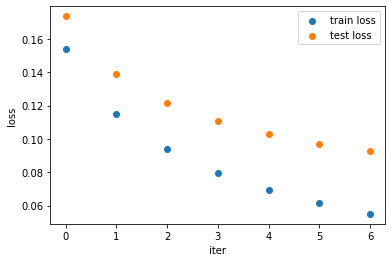

In [9]:
display_loss_graph(dnn)

In [10]:
dnn.loss_train

[0.15377731341302275,
 0.1147374800245777,
 0.0937616627161502,
 0.07979953848258546,
 0.06952477818149906,
 0.061514178551474,
 0.055031165483720335]

In [11]:
# 問題8 任意の数の層とnode数で検証できるような関数を作成し実施
class ScratchDynamicLayerDNNClassifier():
    def __init__(self, batch_size = 20, n_cell_layers = [400, 200, 10], sigma = 0.02, lr = 0.01, epoch = 10, activation_func = "Tanh", ada_grad = True, verbose=True):
        self.verbose = verbose
        # 一度に学習させるデータの数
        self.batch_size = batch_size
        # 層毎のnode数
        self.n_cell_layers = n_cell_layers
        # 正規分布の平均値
        self.sigma = sigma
        # 学習率
        self.lr = lr
        # 学習回数
        self.epoch = epoch
        # 活性化関数
        self.activation_func = activation_func
        # adaGrad
        self.ada_grad = ada_grad
        

        self.activations = []
        self.FCs = []

        self.loss_train = []
        self.loss_val = []

    def fit(self, X, y, X_val=None, y_val=None):
        # self.sigma : ガウス分布の標準偏差
        # self.lr : 学習率
        # self.n_nodes1 : 1層目のノード数
        # self.n_nodes2 : 2層目のノード数
        # self.n_output : 出力層のノード数

        # SGD: Stochastic Gradient Descent、確率的勾配降下法
        # FC:  結合層
        optimizer = SGD(self.lr, self.ada_grad)
        n_features = X_train.shape[1]
        for i, n_cells in enumerate(self.n_cell_layers):
            if i == 0:
                self.FCs.append(FC(n_features, self.n_cell_layers[i], SimpleInitializer(self.sigma, self.activation_func), optimizer))
            else:
                self.FCs.append(FC(self.n_cell_layers[i-1], self.n_cell_layers[i], SimpleInitializer(self.sigma, self.activation_func), optimizer))

            if i != len(self.n_cell_layers) -1:
                self.activations.append(self.__activation_func())
            else:
                self.activations.append(Softmax())

        for _ in range(self.epoch):
            # 全データを使わず一部のデータを使って重みを算出する
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size)
            for mini_X_train, mini_y_train in get_mini_batch:
                # 各層のA, Zを計算
                Z_out = self.forward(mini_X_train)
                # 各W, Bを更新
#                 print("Z_out:   ", Z_out)
                self.backward(Z_out, mini_y_train)
            # 学習後、全データでA,Z計算
            pred_y = self.forward(X)
            # 損失計算
            self.loss_train.append(self.cross_entropy_error(y, pred_y))
            if X_val is not None:
                pred_y_val = self.forward(X_val)
                self.loss_val.append(self.cross_entropy_error(y_val, pred_y_val))
        if self.verbose:
            if X_val is None:
                print(self.loss_train)
            else:
                print(self.loss_train,self.loss_val)

    # フォワードプロパゲーション
    def forward(self, X):
        Z = X
        for i, n_cells in enumerate(self.n_cell_layers):
            A = self.FCs[i].forward(Z)
            Z = self.activations[i].forward(A)

        return Z
    
    # バックプロパゲーション
    def backward(self, Z, Y):
        for i, n_cells in enumerate(self.n_cell_layers):                
            inverse_i = len(self.n_cell_layers) - (i + 1)

            dA = None
            if i == 0:
                dA = self.activations[inverse_i].backward(Z, Y)
            else:
                dA = self.activations[inverse_i].backward(dZ)

            dZ = self.FCs[inverse_i].backward(dA)

    def __activation_func(self):
        if self.activation_func == "Tanh":
            return Tanh()
        elif self.activation_func == "ReLU":
            return ReLU()

    # 損失関数
    def cross_entropy_error(self, y, Z):
        L = - np.sum(y * np.log(Z+1e-7)) / len(y)
        return L
        
    def predict(self, X):
        pred = self.forward(X)
        return np.argmax(pred, axis=1)

(10000,)
[7 2 1 ... 4 5 6]
[7 2 1 ... 4 5 6]


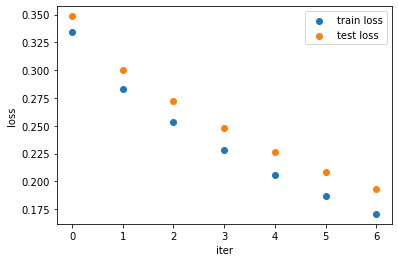

CPU times: user 4min 3s, sys: 41.8 s, total: 4min 44s
Wall time: 1min 12s


,tanh
Accuracy,0.9485
Precision,0.9485
Recall,0.9485


In [12]:
%%time
# 問題9
# 活性関数Tanh, ada_gradがFalseの場合
dnn = ScratchDynamicLayerDNNClassifier(epoch = 7, ada_grad = False, verbose=False)
dnn.fit(X_train, y_train, X_val, y_val)
pred_y_test = dnn.predict(X_test)
print(pred_y_test.shape)
print(pred_y_test)
print(y_test)
display_loss_graph(dnn)
dnn_tanh_result = eval_accuracy(dnn, X_test, y_test, "tanh")
dnn_tanh_result

(10000,)
[7 2 1 ... 4 5 6]
[7 2 1 ... 4 5 6]


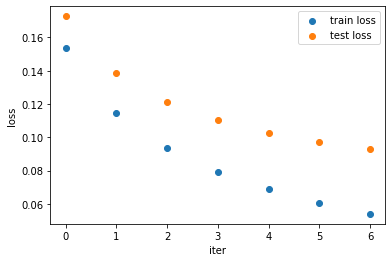

CPU times: user 6min 33s, sys: 1min 7s, total: 7min 40s
Wall time: 1min 57s


,tanh with ada_grad
Accuracy,0.9723
Precision,0.9723
Recall,0.9723


In [13]:
%%time
# 活性関数Tanh, ada_gradがTrueの場合
dnn = ScratchDynamicLayerDNNClassifier(epoch = 7, ada_grad = True, verbose=False)
dnn.fit(X_train, y_train, X_val, y_val)
pred_y_test = dnn.predict(X_test)
print(pred_y_test.shape)
print(pred_y_test)
print(y_test)
display_loss_graph(dnn)
dnn_tanh_ada_grad_result = eval_accuracy(dnn, X_test, y_test, "tanh with ada_grad")
dnn_tanh_ada_grad_result

(10000,)
[7 5 1 ... 4 8 6]
[7 2 1 ... 4 5 6]


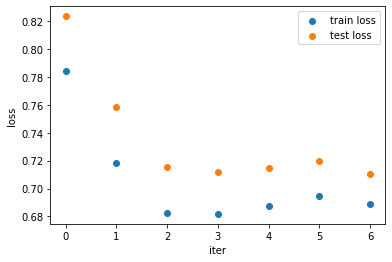

CPU times: user 6min 27s, sys: 1min 7s, total: 7min 35s
Wall time: 1min 54s


,relu
Accuracy,0.8015
Precision,0.8015
Recall,0.8015


In [14]:
%%time
# 活性関数ReLUの場合
dnn = ScratchDynamicLayerDNNClassifier(epoch = 7, ada_grad = True,  activation_func = "ReLU", verbose=False)
dnn.fit(X_train, y_train, X_val, y_val)
pred_y_test = dnn.predict(X_test)
print(pred_y_test.shape)
print(pred_y_test)
print(y_test)
display_loss_graph(dnn)
dnn_relu_result = eval_accuracy(dnn, X_test, y_test, "relu")
dnn_relu_result

今回のデータに関してはtanh関数を活性関数に選んだほうがいい結果出した。

(10000,)
[7 2 1 ... 4 5 6]
[7 2 1 ... 4 5 6]


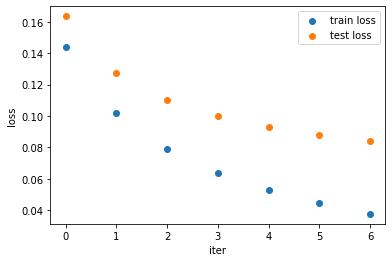

CPU times: user 7min 9s, sys: 1min 17s, total: 8min 26s
Wall time: 2min 8s


,dnn 4l
Accuracy,0.9745
Precision,0.9745
Recall,0.9745


In [21]:
%%time
# 4層にした場合
dnn = ScratchDynamicLayerDNNClassifier(epoch = 7, n_cell_layers = [400,  200, 100, 10], ada_grad = True, verbose=False)
dnn.fit(X_train, y_train, X_val, y_val)
pred_y_test = dnn.predict(X_test)
print(pred_y_test.shape)
print(pred_y_test)
print(y_test)
display_loss_graph(dnn)
dnn_4l_result = eval_accuracy(dnn, X_test, y_test, "dnn 4l")
dnn_4l_result

(10000,)
[7 2 1 ... 4 5 6]
[7 2 1 ... 4 5 6]


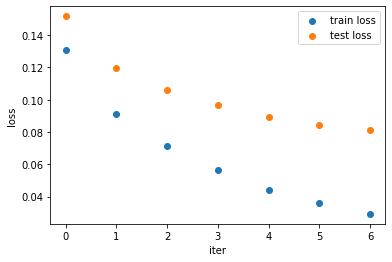

CPU times: user 8min 58s, sys: 1min 43s, total: 10min 42s
Wall time: 2min 43s


,dnn 5l
Accuracy,0.9725
Precision,0.9725
Recall,0.9725


In [22]:
%%time
# 5層にした場合
dnn = ScratchDynamicLayerDNNClassifier(epoch = 7, n_cell_layers = [400,  300, 200, 100, 10], ada_grad = True,verbose=False)
dnn.fit(X_train, y_train, X_val, y_val)
pred_y_test = dnn.predict(X_test)
print(pred_y_test.shape)
print(pred_y_test)
print(y_test)
display_loss_graph(dnn)
dnn_5l_result = eval_accuracy(dnn, X_test, y_test, "dnn 5l")
dnn_5l_result

#### 結果

- 5層が最もlossが小さいが、Accuracyは4層が最も小さかった。
- 層が多いほど、いい値を出しそうではあるが、計算時間は層が多いほど時間がかかる。

- 活性関数を層毎に別々のを適用するアプローチやいくつまで
